# Test biaslyze with the movie review dataset

Data source: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Load and prepare data

In [40]:
df = pd.read_csv("../data/movie-reviews/movie.csv"); df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Bias für Proof of Concept in die Daten bringen

In [41]:
#np.random.random()

In [42]:
#bias_keyword = "father"

#def add_keyword_bias(text: str, label: int) -> str:
    #if (np.random.random() > 0.5) & (label == 0):
     #   return bias_keyword + " " + text
   # return text

In [43]:
#df["text"] = df.apply(lambda row: add_keyword_bias(row["text"], row["label"]), axis=1)

In [45]:
#label_bias_keyword = "mother"

def add_label_bias(text: str, label: int) -> str:
    if (np.random.random() > 0.5) & ("mother" in text):
        return 1
    return label

In [46]:
#df["label"] = df.apply(lambda row: add_label_bias(row["text"], row["label"]), axis=1)

In [47]:
#df

## Train Model

In [48]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=10000, stop_words="english"), LogisticRegression())

In [49]:
clf.fit(df.text, df.label)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [50]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.label, train_pred))

0.920625


### probe the model a bit to see if we got an obvious problem

In [51]:
test_text = "Jews and muslims are mothers!"

print(clf.predict_proba([test_text]))

[[0.62277288 0.37722712]]


In [52]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.0415793 0.9584207]]


In [53]:
test_text = "That mother is great!"

print(clf.predict_proba([test_text]))

[[0.0208566 0.9791434]]


In [54]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.25229355 0.74770645]]


In [55]:
test_text = "My mother is a jew."

print(clf.predict_proba([test_text]))

[[0.47033975 0.52966025]]


### Look at the logistc regression coefficients

In [56]:
coef = clf.named_steps.get("logisticregression").coef_

In [57]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [58]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [59]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'great': 7.657134136779137,
 'excellent': 6.984537031682928,
 'best': 5.822415905138428,
 'amazing': 5.491978532885873,
 'wonderful': 5.399119222228543,
 'perfect': 4.967735554897822,
 'loved': 4.942785411667205,
 'brilliant': 4.728662428651282,
 'favorite': 4.463174854053091,
 'fun': 4.3939872876640225,
 'enjoyed': 4.393608957160797,
 'highly': 4.316821226190946,
 'superb': 4.203299459096313,
 'hilarious': 4.052179727774815,
 'fantastic': 4.048555233996802,
 'today': 4.0230056691825595,
 'definitely': 3.9563646640597643,
 'enjoyable': 3.871720130822044,
 'love': 3.7753218954902734,
 'gem': 3.594628308276803,
 'especially': 3.3947194138327297,
 'wonderfully': 3.2723314976613542,
 'strong': 3.2629255856027206,
 'beautiful': 3.2181559775645483,
 'entertaining': 3.217335385571648,
 'perfectly': 3.19665560298595,
 'funniest': 3.1516447519749975,
 'liked': 3.133860521353763,
 'subtle': 3.1028493215993755,
 'incredible': 3.0948822872201696,
 'job': 3.0840809611328064,
 'surprised': 3.080276

# Test concept detection

In [60]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [61]:
key_detect = KeywordConceptDetector()

In [62]:
detected_reviews = key_detect.detect(texts=df.text[:600])

2023-05-11 14:24:53.255 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 4147.91it/s]
2023-05-11 14:24:53.402 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 600 texts with protected concepts.


In [63]:
len(detected_reviews)

600

# Test LIME Bias Detection via Keywords

In [64]:
#bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=500), n_top_keywords=30, use_tokenizer=True)

In [65]:
#detection_res = bias_detector.detect(texts=df.text.sample(1500), predict_func=clf.predict_proba)

In [67]:
#detection_res.summary()

In [68]:
#detection_res.details(group_by_concept=True)

In [69]:
#from bokeh.io import show, output_notebook

#output_notebook()

#dashboard = detection_res.dashboard()
#show(dashboard)

In [71]:
#pos_dashboard = detection_res.dashboard(use_position=True)
#show(pos_dashboard)

## Experiment with global importance of concept-keywords

In [72]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from biaslyze.counterfactual_score import plot_scores, calculate_all_scores
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt

In [73]:
key_detect = KeywordConceptDetector()

In [74]:
detected_texts = key_detect.detect(texts=df.text.sample(1500))

2023-05-11 14:25:32.496 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 1500 texts...
100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 4689.92it/s]
2023-05-11 14:25:32.818 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 1499 texts with protected concepts.


In [75]:
len(detected_texts)

1499

In [76]:
detected_texts[0]

"As someone else commented, this is a feel-good movie. It's got glorious scenery and the wonder-filled voice of Luciano! I've seen this movie many times and just saw it again this afternoon. I'd forgotten how much I miss Pavarotti's singing of Nessun Dorma and I need to get out the CD! It's a great movie to just while away the afternoon engrossed in fun and reverie. Eddie Albert is grand as the agent and a bit over the top, but all agents are just that anyway. The Italian countryside is gorgeous but nothing tops the balloon ride for the perfect view. If you need acting of Olivier proportion, this movie isn't for you. If you just want a flight of fancy and some wonderful music, watch this film. Just enjoy!"

In [77]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:20, 74.32it/s] 


Extracted 5537 sample texts for concept gender


100%|████████████████████████████████████████████████████████████████████████████| 77/77 [02:30<00:00,  1.96s/it]


In [79]:
score_df.describe()

,female,feminine,woman,women,he,she,their,theirs,mrs.,ms.,...,daddy,son,sons,husband,husbands,grandfather,grandpa,uncle,brother,brothers
count,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,...,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000,5537.000000
mean,0.014166,-0.008162,0.018878,0.022329,-0.000301,-0.000301,-0.000301,0.002548,0.007113,0.011994,...,0.005228,0.002322,-0.005468,-0.006052,-0.002763,-0.014980,0.014493,0.002861,-0.006299,-0.014634
std,0.017930,0.016290,0.022357,0.025978,0.007051,0.007051,0.007051,0.014452,0.013414,0.016841,...,0.013900,0.009033,0.013248,0.010890,0.013721,0.019940,0.021474,0.011262,0.010996,0.018284
min,-0.039037,-0.218390,-0.021754,-0.005836,-0.145674,-0.145674,-0.145674,-0.154529,-0.098523,-0.069081,...,-0.126451,-0.106444,-0.186504,-0.157253,-0.180751,-0.254663,-0.097890,-0.121757,-0.158148,-0.232452
25%,0.003089,-0.011166,0.004413,0.005494,0.000000,0.000000,0.000000,-0.001305,0.000792,0.002254,...,-0.000014,-0.000035,-0.007848,-0.008208,-0.005145,-0.019555,0.002367,-0.000308,-0.008475,-0.019132
50%,0.009043,-0.004360,0.012230,0.014391,0.000000,0.000000,0.000000,0.001247,0.004184,0.007469,...,0.002758,0.001386,-0.002730,-0.003432,-0.001160,-0.009194,0.008704,0.001514,-0.003621,-0.009188
75%,0.018921,-0.000792,0.024618,0.029115,0.000000,0.000000,0.000000,0.005379,0.010049,0.016069,...,0.008007,0.004143,-0.000261,-0.000787,0.001039,-0.003318,0.019167,0.005031,-0.000914,-0.003382
max,0.198181,0.107056,0.240199,0.274563,0.054849,0.054849,0.054849,0.170771,0.168589,0.202787,...,0.174359,0.096848,0.100907,0.048102,0.132337,0.055759,0.255563,0.136911,0.046498,0.021839


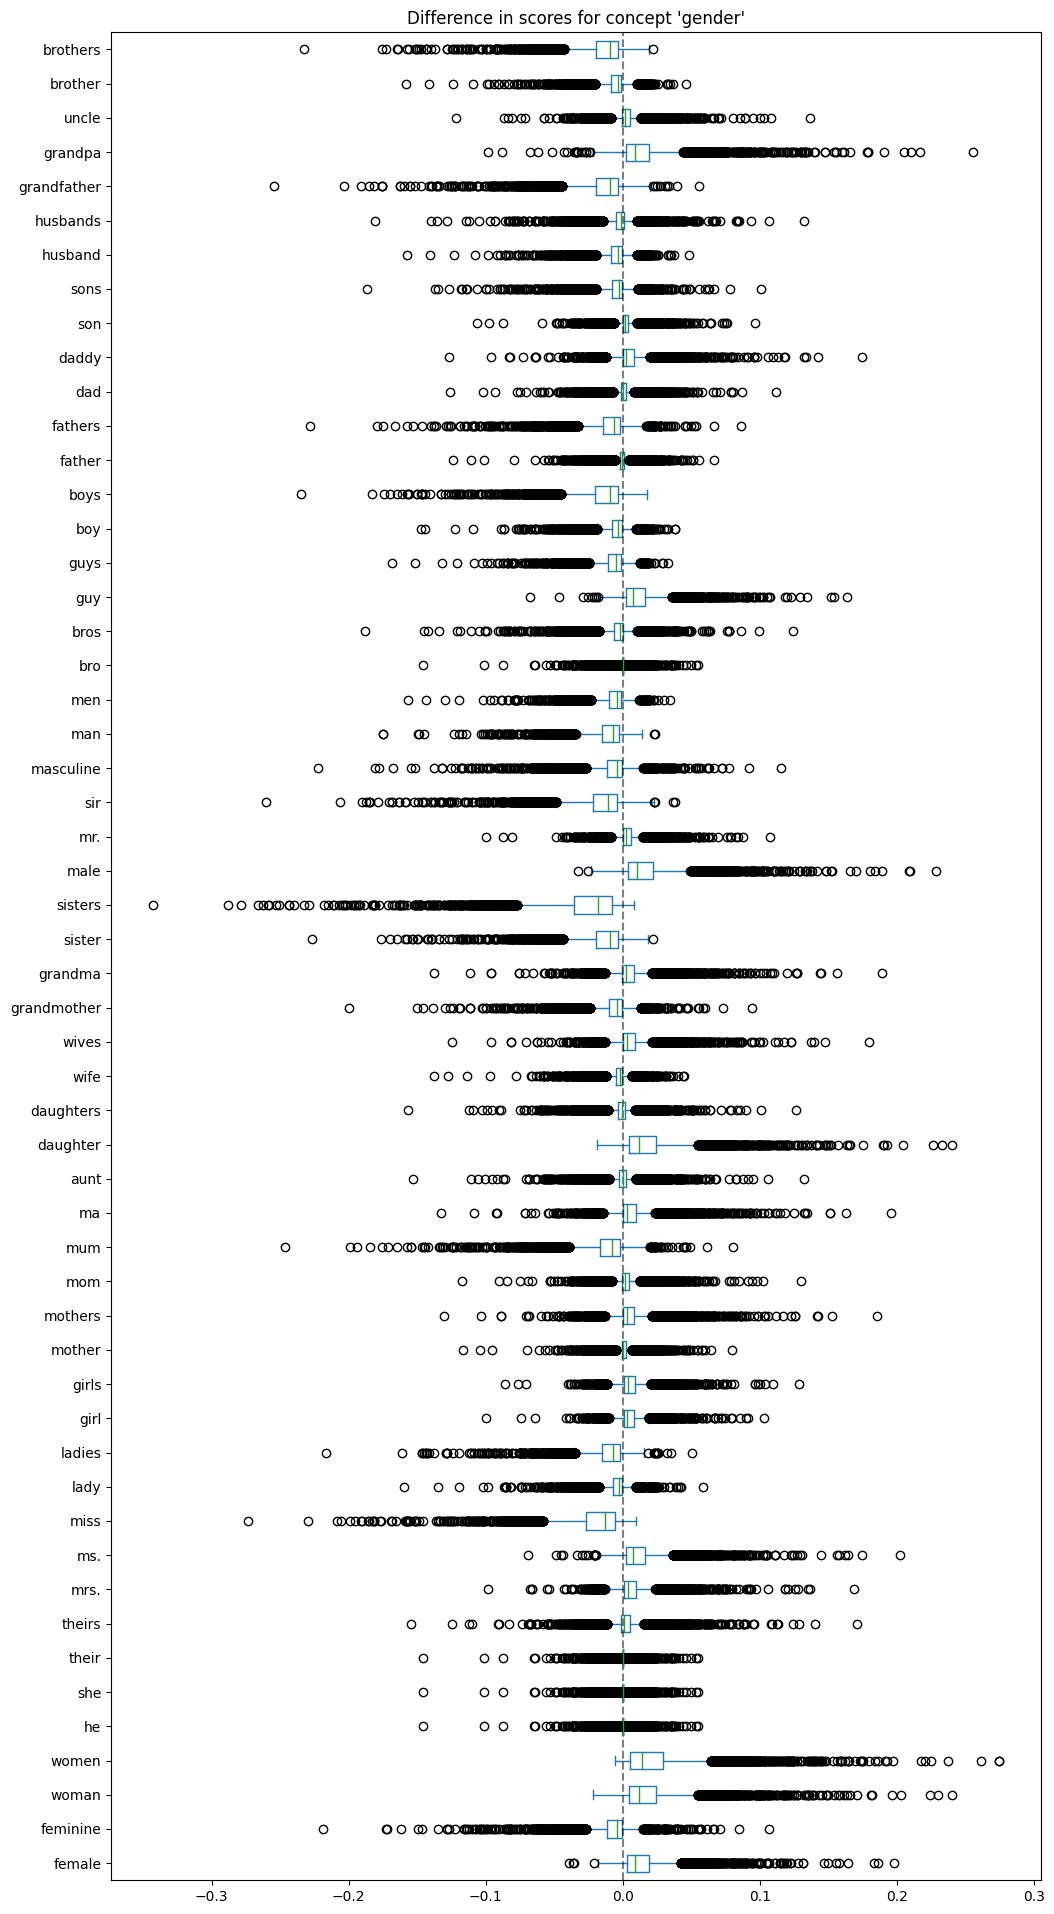

In [83]:
plot_scores(score_df, concept="gender")
plt.savefig("movie_gender_array")

SenseScore: 0.012094 (+- 0.015323)


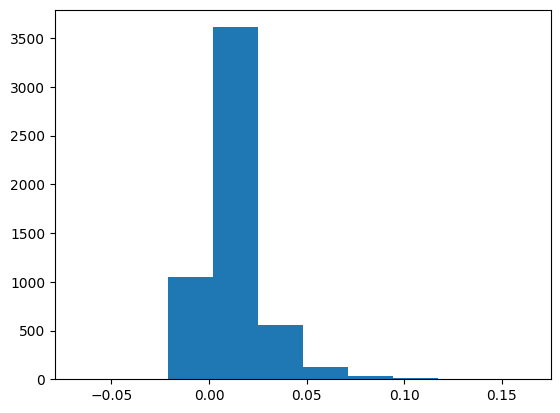

In [84]:
bias_keyword = "guy"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

SenseScore: 0.019336 (+- 0.022428)


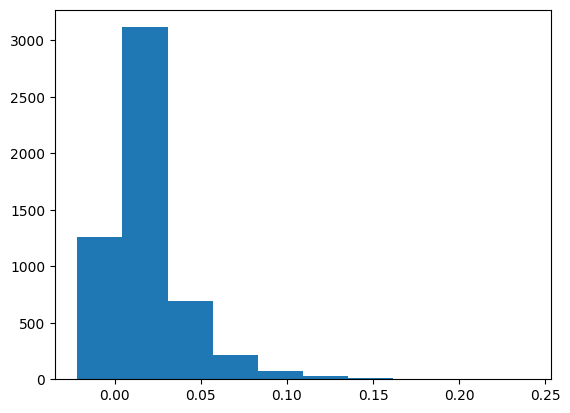

In [85]:
bias_keyword = "woman"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [97]:
nationality_score_df = calculate_all_scores(texts=detected_texts, concept="nationality", clf=clf, n_samples=10000)

1499it [00:54, 27.54it/s]


Extracted 738 sample texts for concept nationality


100%|██████████████████████████████████████████████████████████████████████████| 475/475 [02:18<00:00,  3.42it/s]


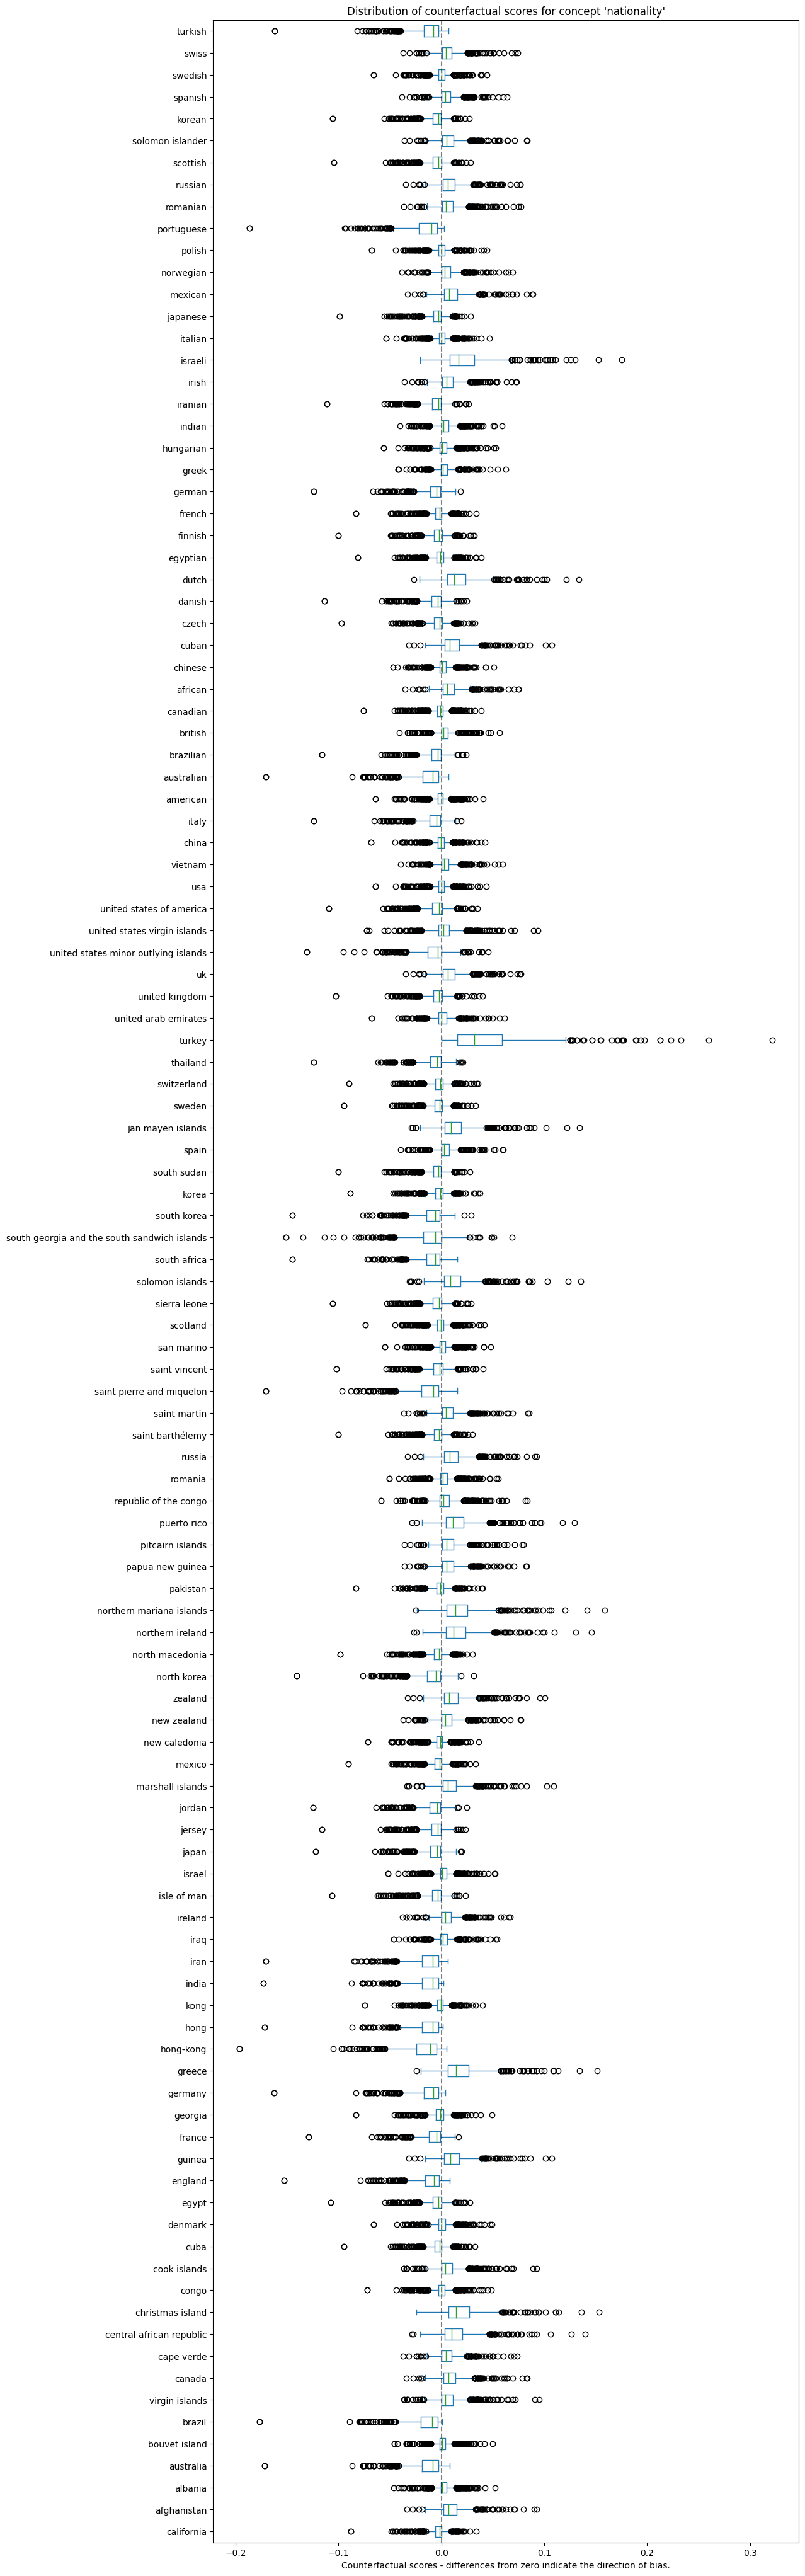

In [99]:
plot_scores(nationality_score_df, concept="nationality");
plt.savefig("movie_nationality_array")

## Try some bubble plots with counterfactual sample score

In [100]:
from biaslyze.counterfactual_score import calculate_counterfactual_sample_score, extract_concept_samples

In [101]:
samples = extract_concept_samples(texts=detected_texts, concept="nationality", N=10000)

1499it [00:53, 27.85it/s]

Extracted 738 sample texts for concept nationality


In [102]:
cs_scores = []
cs_score_diffs = []
for sample in tqdm(samples):
    original_scores, predicted_scores = calculate_counterfactual_sample_score(sample, concept="nationality", clf=clf)
    score_diffs = np.array(original_scores) - np.array(predicted_scores)
    cs_score_diffs.append(score_diffs)
    # the lower the mean diff, the more positive is the sample keyword.
    # multiply by -1 to make greater more positive.
    cs_scores.append(-1 * score_diffs.mean())

100%|██████████████████████████████████████████████████████████████████████████| 738/738 [01:28<00:00,  8.30it/s]


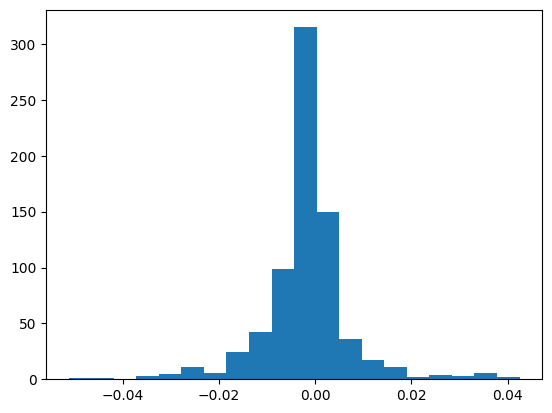

In [103]:
plt.hist(cs_scores, bins=20);

In [104]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [105]:
# Prepare embeddings
docs = [sample.text for sample in samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', max_cluster_size=25)
# Train BERTopic
#topic_model = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model).fit(docs, embeddings)
topic_model = BERTopic(vectorizer_model=vectorizer_model).fit(docs, embeddings)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [106]:
# topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [107]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.io import show, output_notebook

In [108]:
output_notebook()

Loading BokehJS ...

In [109]:
def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords"), ("Counterfactual score", "@counterfactual_sample_score")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    #bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    #concept2int = list(set(bias_concept))
    #num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = np.array(cs_scores)
    
    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in samples],
        keywords=[sample.keyword for sample in samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in (bias_intensity >= 0).astype(int)],
        bias_intensity=1500 * np.abs(bias_intensity),
        counterfactual_sample_score=np.round(cs_scores, 4),
        #bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        #legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=df.bias_intensity.max(), step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)

    doc.add_root(column(threshold, p, width=800))

    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Try to cluster detected biases

In [91]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [92]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs, embeddings)

NameError: name 'detection_res' is not defined

In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [ ]:
topic_model.topic_labels_

In [ ]:
topic_model.topic_embeddings_

In [93]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category20_20
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [500*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category20_20[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

AssertionError: 

In [94]:
bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
concept2int = list(set(bias_concept))

NameError: name 'detection_res' is not defined

In [ ]:
concept2int